In [1]:
# IMPORTAÇÃO DE BLIBLIOTECAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# CARREGAMENTO DE DADOS
df_consultas = pd.read_csv('consultas.csv')
df_avaliacoes = pd.read_csv('avaliacoes.csv')
df_clinicas = pd.read_csv('clinicas.csv')
df_medicos = pd.read_csv('medicos.csv', sep= ';')
df_pacientes = pd.read_csv('pacientes.csv')

# CONVERSÃO DE COLUNAS DATA/HORA PARA DATETIME colunas de data/hora para datetime
df_consultas['data_hora_agendada'] = pd.to_datetime(df_consultas['data_hora_agendada'])
df_consultas['data_hora_inicio'] = pd.to_datetime(df_consultas['data_hora_inicio'])

# CRIANDO COLUNA TEMPO DE ESPERA, E PROGRAMANDO SER CALCULADA EM MINUTOS
df_consultas['tempo_espera'] = (df_consultas['data_hora_inicio'] - df_consultas['data_hora_agendada']).dt.total_seconds() / 60


,id_paciente,idade,sexo,cidade,plano_saude
0,1,21,M,Manaus,Sim
1,2,15,M,Brasília,Sim
2,3,86,M,Salvador,Não
3,4,87,M,Manaus,Sim
4,5,56,M,Porto Alegre,Não
...,...,...,...,...,...
95,96,47,M,Recife,Sim
96,97,12,F,Manaus,Não
97,98,64,M,Fortaleza,Sim
98,99,28,M,Rio de Janeiro,Não


In [14]:
df_col_cli = pd.merge(df_correlacao, df_clinicas, left_on='id_clinica', right_on='id_clinica',
how='inner')
df_col_cli

,id_consulta,id_paciente,id_medico,id_clinica,especialidade,data_hora_agendada,data_hora_inicio,status,tempo_espera,nota_satisfacao,comentario,nome,cidade,capacidade_diaria
0,9,69,16,49,Ortopedia,2023-01-29 16:33:00,2023-01-29 20:33:00,Realizada,240.0,4,Comentário 3,Saúde Total,Manaus,20
1,85,34,23,75,Ortopedia,2023-04-07 15:40:00,2023-04-07 15:40:00,Realizada,0.0,1,Comentário 97,Clínica Vital,Curitiba,35
2,231,80,72,42,Pediatria,2023-11-30 05:37:00,2023-11-30 10:37:00,Realizada,300.0,2,Comentário 60,Vida Plena,Rio de Janeiro,37
3,372,51,92,93,Ginecologia,2023-06-24 06:38:00,2023-06-24 10:38:00,Realizada,240.0,4,Comentário 50,Clínica Horizonte,Belo Horizonte,54
4,411,34,84,100,Ginecologia,2023-07-30 14:47:00,2023-07-30 19:47:00,Realizada,300.0,2,Comentário 35,Clínica Esperança,Manaus,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,4743,79,71,42,Neurologia,2023-02-09 14:03:00,2023-02-09 19:03:00,Realizada,300.0,5,Comentário 14,Vida Plena,Rio de Janeiro,37
60,4874,52,88,93,Ortopedia,2023-06-11 05:05:00,2023-06-11 05:05:00,Realizada,0.0,5,Comentário 29,Clínica Horizonte,Belo Horizonte,54
61,4880,99,27,99,Pediatria,2023-10-20 19:55:00,2023-10-20 20:10:00,Realizada,15.0,2,Comentário 96,Bem Viver,Salvador,71
62,4916,85,19,39,Cardiologia,2023-03-01 02:15:00,2023-03-01 03:15:00,Realizada,60.0,2,Comentário 44,Clínica São Lucas,Salvador,83


In [ ]:
# FUNÇÕES DE ANÁLISE E VISUALIZAÇÃO

def analisar_tempo(df_especialidade):
    '''Agrupa por coluna e retorna média e mediana do tempo de espera.'''
    array = np.array(df_especialidade['tempo_espera'])
    q1, q2, q3 = np.percentile(array, [25, 50, 75])
    media = np.mean(array)
    mediana = np.median(array)
    distancia = (media - mediana) / mediana
    iqr = q3 - q1
    limite_inf, limite_sup = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = (array < limite_inf) | (array > limite_sup)
    outlier_sup = df_especialidade.loc[df_especialidade['tempo_espera'] > q3]
    outlier_inf = df_especialidade.loc[df_especialidade['tempo_espera'] < q1]
    return {
        "Q1": q1,
        "Q2": q2,
        "Q3": q3,
        "Média": media,
        "Mediana": mediana,
        "Distância %": distancia * 100,
        "Outliers": outliers.sum()                             
    }

def calcular_estatisticas_por(df, coluna_grupo):
    '''Agrupa por coluna e retorna média e mediana do tempo de espera.'''
    media = df.groupby(coluna_grupo)['tempo_espera'].mean().reset_index(name='tempo_espera_media')
    mediana = df.groupby(coluna_grupo)['tempo_espera'].median().reset_index(name='tempo_espera_mediana')
    return media.merge(mediana, on=coluna_grupo)

def gerar_grafico_barras(df, x_col, media_col, mediana_col, titulo, xlabel):
    '''Gera gráfico de barras comparando média e mediana.'''
    x = df[x_col]
    x_indices = range(len(x))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x_indices, df[media_col], width=width, label='Média')
    plt.bar([i + width for i in x_indices], df[mediana_col], width=width, label='Mediana')

    plt.xticks([i + width / 2 for i in x_indices], x, rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel('Tempo de Espera (min)')
    plt.title(titulo)
    plt.legend()
    plt.tight_layout()
    plt.show()

def gerar_grafico_dispersao(x, y, titulo, xlabel, ylabel):
    '''Gera gráfico de dispersãocom Matplotlib.'''
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.6)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titulo)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
# ESTATÍSTICAS POR ESPECIALIDADE

dfs_por_especialidade = {
    esp: df for esp, df in df_consultas.groupby("especialidade")
}

# TRANSFORMANDO EM DATAFRAME, UTILIZANDO O "T" PARA INVERTER O DATAFRAME E TROCANDO LINHAS POR COLUNAS9
resultados = {esp: analisar_tempo(df) for esp, df in dfs_por_especialidade.items()}
df_resultados = pd.DataFrame(resultados).T
print(df_resultados)

                Q1    Q2     Q3       Média Mediana Distância % Outliers  \
Cardiologia   10.0  60.0  180.0   96.148649    60.0   60.247748        0   
Dermatologia  10.0  60.0  180.0    97.58483    60.0   62.641384        0   
Ginecologia   10.0  30.0  180.0   95.841523    30.0  219.471744        0   
Neurologia    10.0  60.0  180.0  100.522727    60.0   67.537879        0   
Ortopedia     10.0  30.0  180.0   94.038634    30.0  213.462114        0   
Pediatria     10.0  30.0  180.0   93.013699    30.0  210.045662        0   

                                                   OUTLINER INF  \
Cardiologia         id_consulta  id_paciente  id_medico  id_...   
Dermatologia        id_consulta  id_paciente  id_medico  id_...   
Ginecologia         id_consulta  id_paciente  id_medico  id_...   
Neurologia          id_consulta  id_paciente  id_medico  id_...   
Ortopedia           id_consulta  id_paciente  id_medico  id_...   
Pediatria           id_consulta  id_paciente  id_medico  id_...  

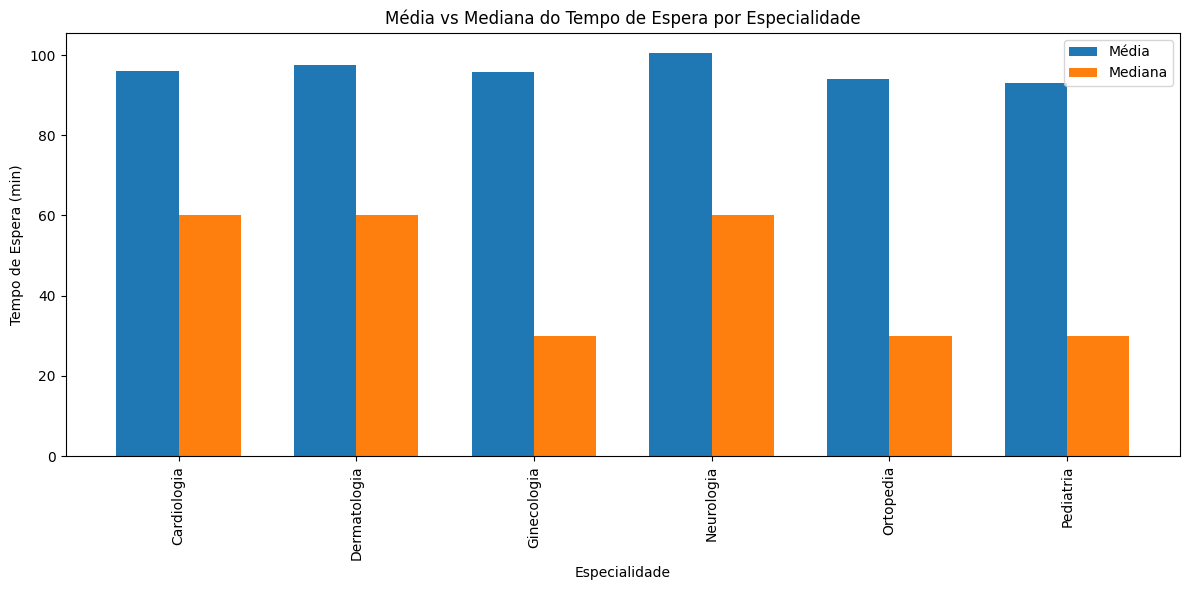

C:\Users\cmjfe\AppData\Local\Temp\ipykernel_6548\702154518.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=list(dfs_por_especialidade.keys()), patch_artist=True, showmeans=True)


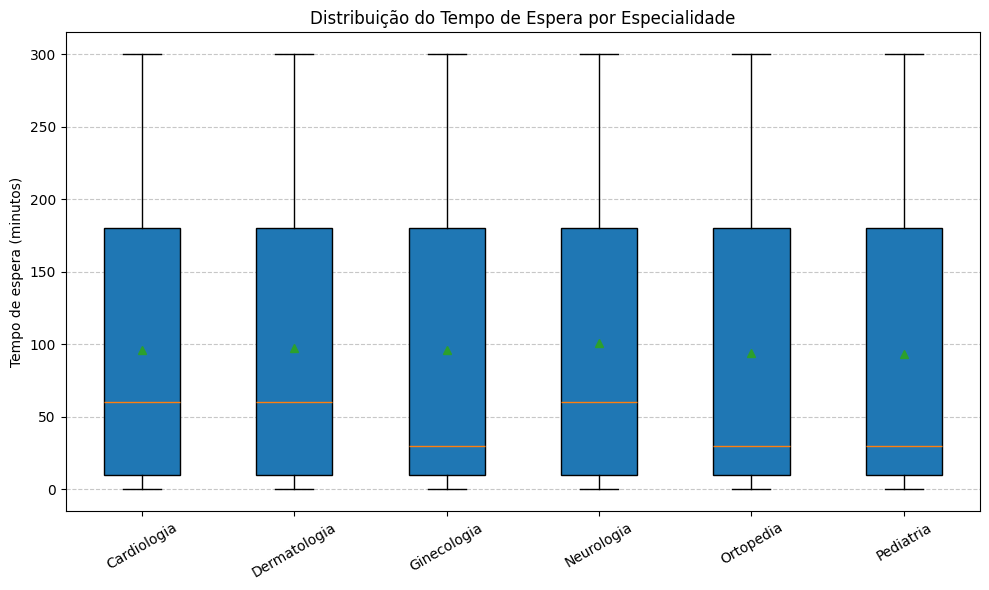

In [5]:
# GRÁFICO MEDIA E MEDIANA POR ESPECIALIDADE
df_esp = calcular_estatisticas_por(df_consultas, 'especialidade')
gerar_grafico_barras(df_esp, 'especialidade', 'tempo_espera_media', 'tempo_espera_mediana',
                     'Média vs Mediana do Tempo de Espera por Especialidade', 'Especialidade')

# BOXPLOT POR ESPECIALIDADE
plt.figure(figsize=(10, 6))
dados = [dfs_por_especialidade[esp]['tempo_espera'].dropna() for esp in dfs_por_especialidade]
plt.boxplot(dados, labels=list(dfs_por_especialidade.keys()), patch_artist=True, showmeans=True)
plt.title("Distribuição do Tempo de Espera por Especialidade")
plt.ylabel("Tempo de espera (minutos)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


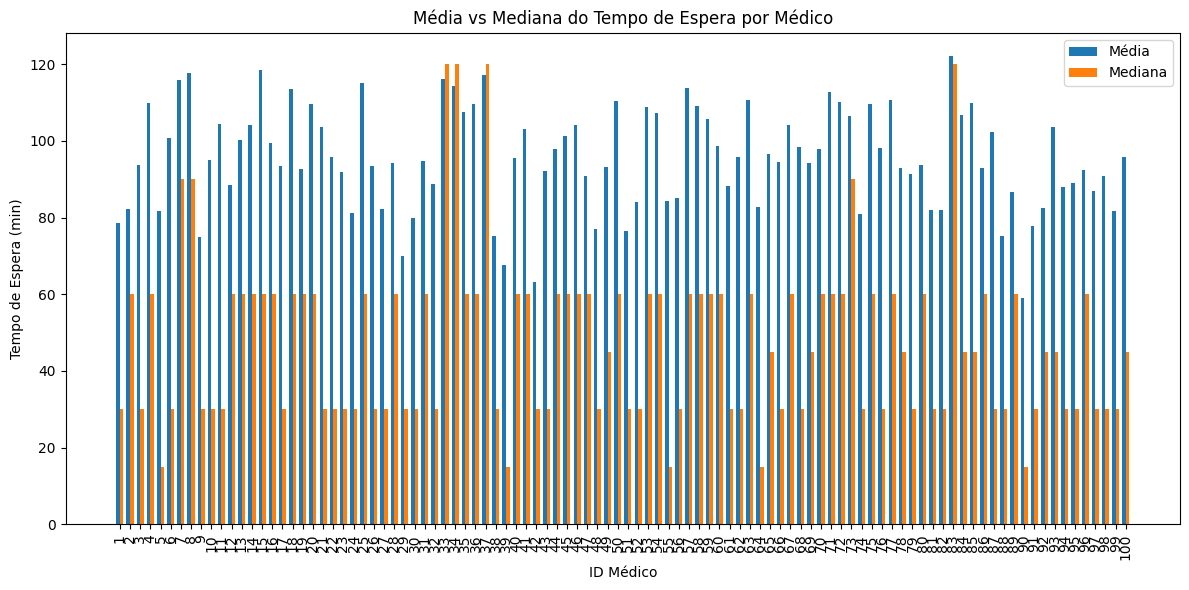

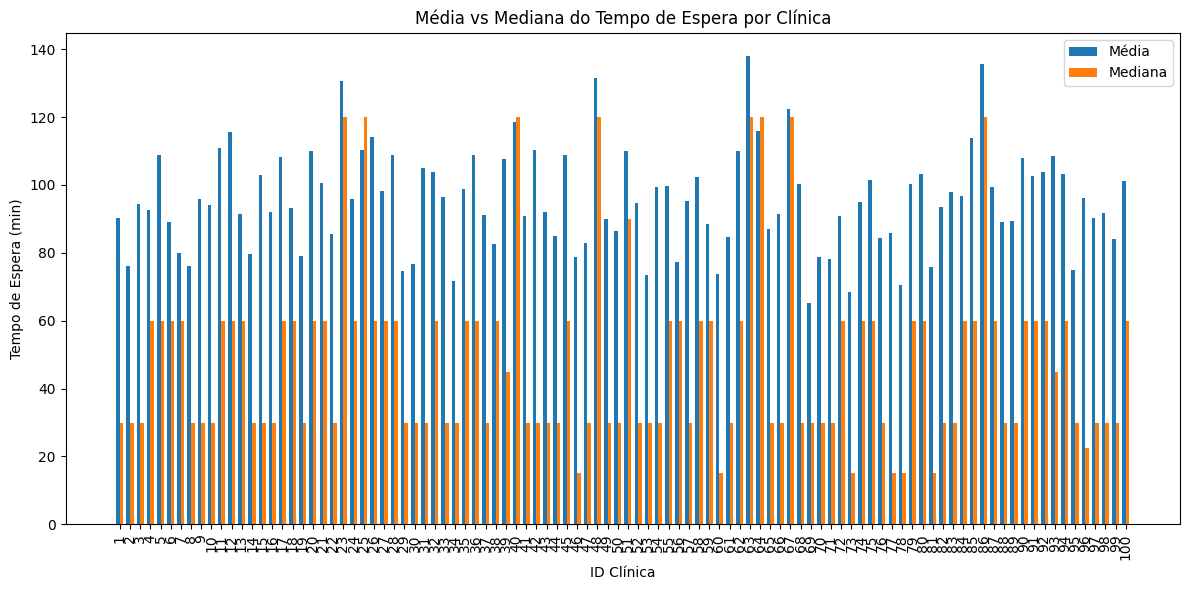

In [6]:
# ESTATÍSTICAS POR MÉDICO
df_med = calcular_estatisticas_por(df_consultas, 'id_medico')
gerar_grafico_barras(df_med, 'id_medico', 'tempo_espera_media', 'tempo_espera_mediana',
                     'Média vs Mediana do Tempo de Espera por Médico', 'ID Médico')

# ESTATÍSTICAS POR CLÍNICA
df_cli = calcular_estatisticas_por(df_consultas, 'id_clinica')
gerar_grafico_barras(df_cli, 'id_clinica', 'tempo_espera_media', 'tempo_espera_mediana',
                     'Média vs Mediana do Tempo de Espera por Clínica', 'ID Clínica')


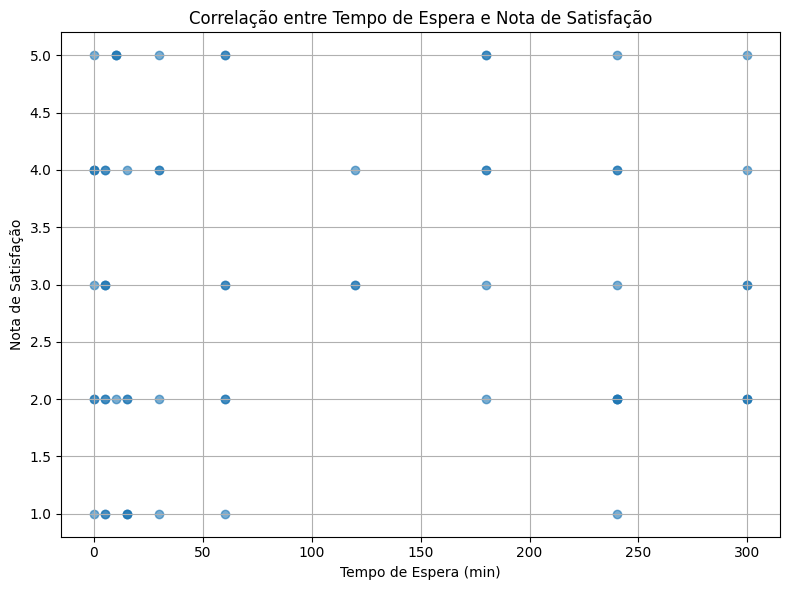

Correlação: 0.05


In [10]:
# CORRELAÇÃO ENTRE TEMPO DE ESPERA E NOTA DE SATISFAÇÃO

df_correlacao = df_consultas.merge(df_avaliacoes, on='id_consulta')
df_correlacao = df_correlacao.loc[
    df_correlacao['tempo_espera'].notnull() & (df_correlacao['status'] == 'Realizada')
]

#df_correlacao.to_csv("df_correlacao.csv", index=False, encoding="utf-8-sig", decimal=",")

gerar_grafico_dispersao(df_correlacao['tempo_espera'],
                        df_correlacao['nota_satisfacao'],
                        'Correlação entre Tempo de Espera e Nota de Satisfação',
                        'Tempo de Espera (min)',
                        'Nota de Satisfação')

correlacao = df_correlacao['tempo_espera'].corr(df_correlacao['nota_satisfacao'])
print(f'Correlação: {correlacao:.2f}')
